<a href="https://colab.research.google.com/github/PatrykGluszekDS/TensorFlow-Projects-Showcase/blob/main/CNN/Intel_Natural_Scence_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


## 1 . Exploratory Data Analysis  

Answer two questions:

1. **How many images per class and split?**  
2. **What do representative samples look like?**  

This quick scan spots class imbalance, corrupted files, or unexpected resolutions before GPU training.

In [5]:
BASE_DIR  = Path('/kaggle/input/intel-image-classification')
TRAIN_DIR = BASE_DIR / 'seg_train' / 'seg_train'
TEST_DIR  = BASE_DIR / 'seg_test'  / 'seg_test'

In [6]:
def count_per_class(root: Path) -> dict:
    return {p.name: len(list(p.glob('*'))) for p in root.iterdir() if p.is_dir()}

counts = pd.DataFrame({
    'train': count_per_class(TRAIN_DIR),
    'test' : count_per_class(TEST_DIR)
}).fillna(0).astype(int)

display(counts)
print(f"Total images: {counts.sum().sum():,}")

,train,test
mountain,2512,525
street,2382,501
buildings,2191,437
sea,2274,510
forest,2271,474
glacier,2404,553


Total images: 17,034


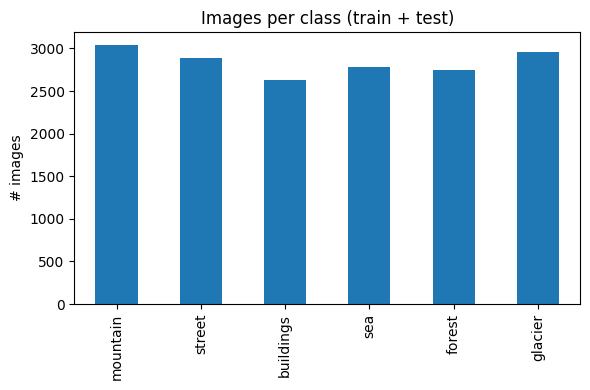

In [10]:
counts.sum(axis=1).plot.bar(figsize=(6,4))
plt.title('Images per class (train + test)')
plt.ylabel('# images')
plt.tight_layout()
plt.savefig('class_distribution.png')   # for README
plt.show()

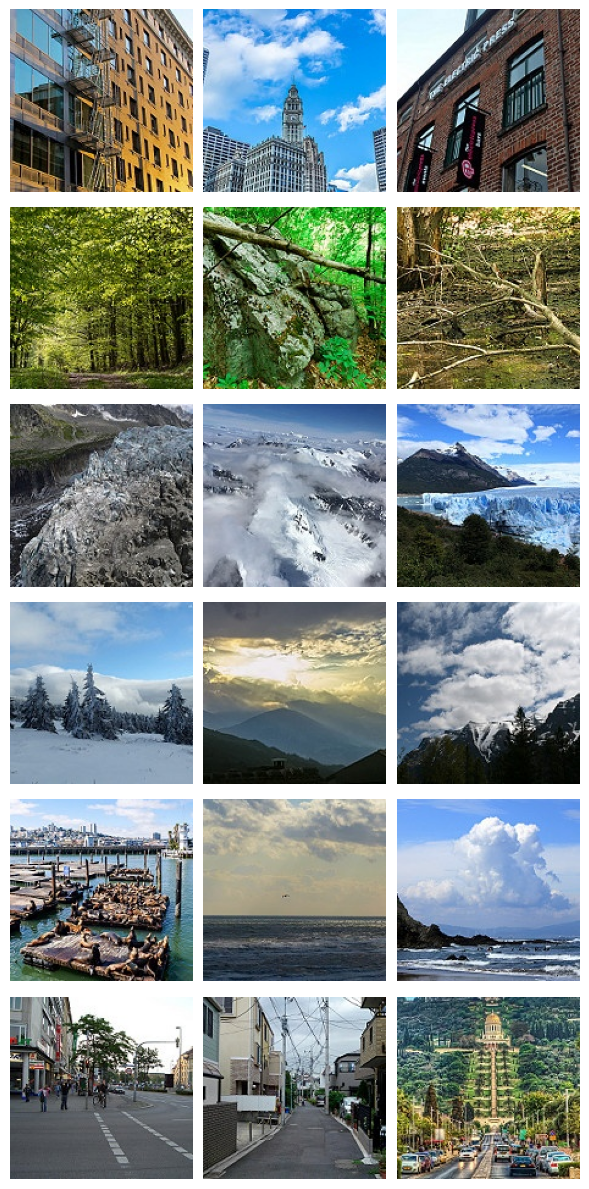

In [12]:
def show_samples(root=TRAIN_DIR, n_per_class=3, size=150):
    classes = sorted([p for p in root.iterdir() if p.is_dir()])
    fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class*2, len(classes)*2))
    for r, cls_path in enumerate(classes):
        samples = random.sample(list(cls_path.glob('*')), n_per_class)
        for c, img_path in enumerate(samples):
            axes[r, c].imshow(Image.open(img_path))
            axes[r, c].axis('off')
            if c == 0:
                axes[r, c].set_ylabel(cls_path.name, rotation=0, labelpad=40, fontsize=9, weight='bold')
    plt.tight_layout()
    plt.show()

show_samples()

## Baseline input pipeline - no data augmentation

In [15]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(TRAIN_DIR,
                                               target_size=(150, 150),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(TEST_DIR,
                                             target_size=(150, 150),
                                             batch_size=32,
                                             class_mode="categorical")

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Creating the model

In [19]:
model_1 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(150, 150, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Flatten(),
    Dense(6, activation="softmax")
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Fitting a model

In [20]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5016 - loss: 1.2151

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 111s 247ms/step - accuracy: 0.5019 - loss: 1.2145 - val_accuracy: 0.6880 - val_loss: 0.8178
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.7543 - loss: 0.6824 - val_accuracy: 0.7430 - val_loss: 0.7376
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.7973 - loss: 0.5734 - val_accuracy: 0.7633 - val_loss: 0.6539
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.8340 - loss: 0.4788 - val_accuracy: 0.7753 - val_loss: 0.6635
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.8672 - loss: 0.3857 - val_accuracy: 0.7727 - val_loss: 0.6988


## Evaluating

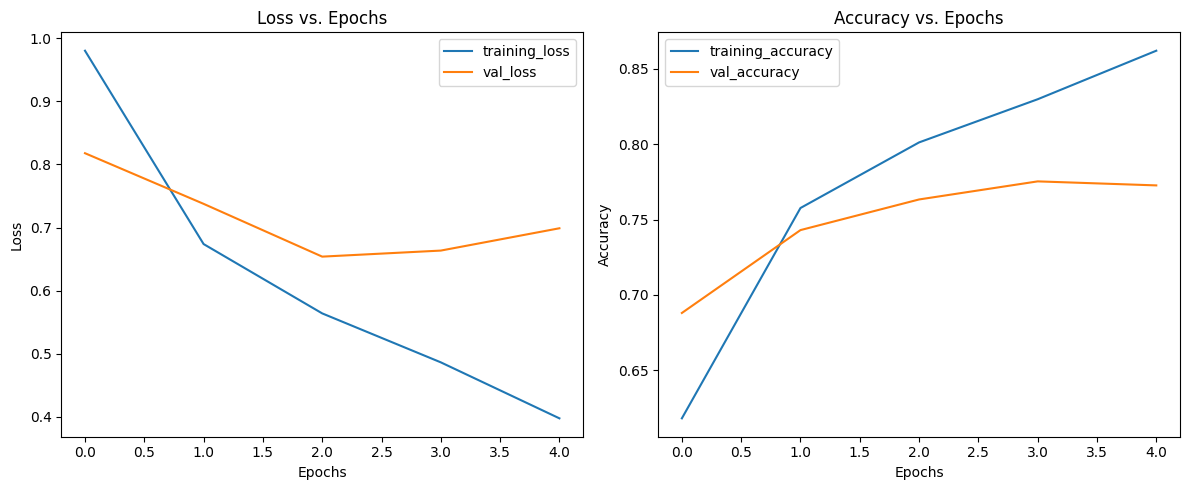

In [21]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history):
    """
    Plots the training and validation loss and accuracy from a model's history.

    Args:
        history: A Keras History object.
    """
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='training_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history_1)

In [22]:
model_1.evaluate(test_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7823 - loss: 0.6750


[0.6988396644592285, 0.7726666927337646]

## Data augmentation

In [23]:
# Create an augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(TRAIN_DIR,
                                                                    target_size=(150, 150),
                                                                    batch_size=32,
                                                                    class_mode="categorical")

Found 14034 images belonging to 6 classes.


In [24]:
# Let's create another model but this time we'll fit it on the augmented data
model_2 = tf.keras.models.clone_model(model_1)

# Compile the cloned model (using the same setup as previous models)
model_2.compile(loss="categorical_crossentropy",
                 optimizer=Adam(),
                 metrics=["accuracy"])

In [25]:
# Fit the model
history_2 = model_2.fit(train_data_augmented,
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 97s 216ms/step - accuracy: 0.4575 - loss: 1.2814 - val_accuracy: 0.6667 - val_loss: 0.8692
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 94s 214ms/step - accuracy: 0.6317 - loss: 0.9405 - val_accuracy: 0.7353 - val_loss: 0.7314
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 94s 214ms/step - accuracy: 0.6982 - loss: 0.7915 - val_accuracy: 0.7383 - val_loss: 0.7250
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 94s 214ms/step - accuracy: 0.7078 - loss: 0.7800 - val_accuracy: 0.7660 - val_loss: 0.6571
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 215ms/step - accuracy: 0.7231 - loss: 0.7450 - val_accuracy: 0.7440 - val_loss: 0.7064


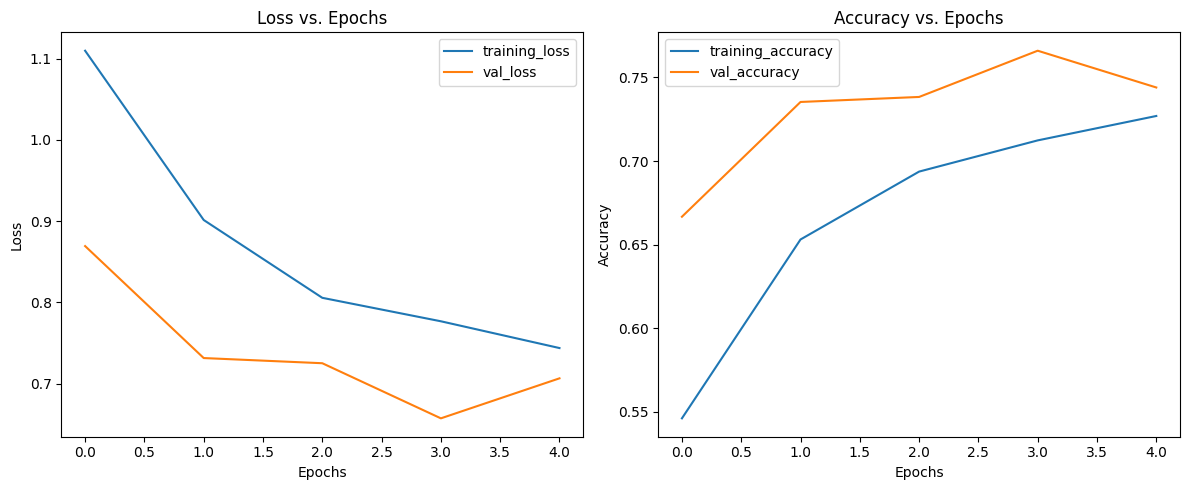

In [26]:
plot_loss_accuracy(history_2)

In [27]:
model_2.evaluate(test_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7418 - loss: 0.7292


[0.7063966393470764, 0.7440000176429749]

## Pulling the levers

In [28]:
train_datagen_augmented_2 = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.1,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             zoom_range=0.1,
                                             horizontal_flip=True)

train_data_augmented_2 = train_datagen_augmented.flow_from_directory(TRAIN_DIR,
                                                                    target_size=(150, 150),
                                                                    batch_size=32,
                                                                    class_mode="categorical")

Found 14034 images belonging to 6 classes.


In [30]:
model_3 = Sequential([
    Conv2D(32, 3, activation="relu", input_shape=(150, 150, 3)),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(64, 3, activation="relu"),
    Conv2D(64, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(128, 3, activation="relu"),
    Conv2D(128, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Flatten(),
    Dense(6, activation="softmax")
])

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# Fit the model
history_3 = model_3.fit(train_data_augmented_2,
                          epochs=20,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 109s 231ms/step - accuracy: 0.4562 - loss: 1.3235 - val_accuracy: 0.6050 - val_loss: 0.9363
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 217ms/step - accuracy: 0.6523 - loss: 0.8850 - val_accuracy: 0.7350 - val_loss: 0.6686
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 216ms/step - accuracy: 0.7198 - loss: 0.7450 - val_accuracy: 0.7957 - val_loss: 0.5655
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 216ms/step - accuracy: 0.7488 - loss: 0.6746 - val_accuracy: 0.8020 - val_loss: 0.5490
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 217ms/step - accuracy: 0.7771 - loss: 0.6123 - val_accuracy: 0.8217 - val_loss: 0.4922
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 216ms/step - accuracy: 0.7995 - loss: 0.5429 - val_accuracy: 0.8253 - val_loss: 0.5052
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 217ms/step - accuracy: 0.8066 - loss: 0.5324 - val_accuracy: 0.8360 - val_loss: 0.4557
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 215ms/step - accuracy: 0.8121 - loss: 

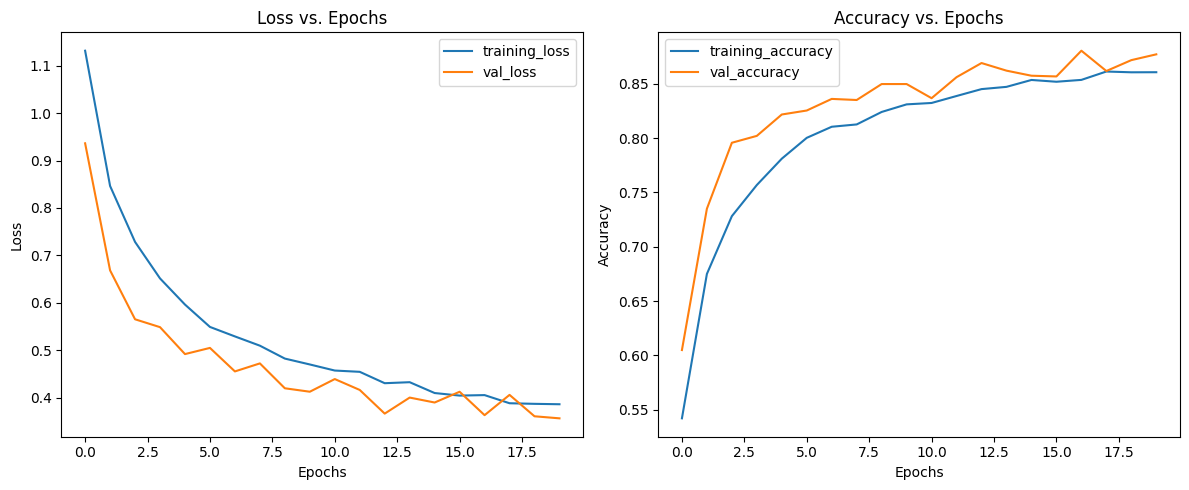

In [32]:
plot_loss_accuracy(history_3)

In [33]:
model_3.evaluate(test_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8843 - loss: 0.3336


[0.35685932636260986, 0.8769999742507935]